# Definitions and Environment

## Libraries and Settings

In [1]:
import os.path as osp
import time
import pickle
import os
from datetime import datetime
import warnings

import torch
from torch_geometric.nn import GATConv
from torch_geometric.nn.models import VGAE
import torch.nn.functional as F
import numpy as np
import random
import itertools
import networkx as nx
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import make_interp_spline

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Dataset, Data
from torch.nn import GRU
from torch_geometric.utils import to_dense_adj

import matplotlib.pyplot as plt
import seaborn as sns

import pprint

In [2]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cpu


In [3]:
# Plot settings
if osp.exists("./files/paper.mplstyle"):
    plt.style.use("./files/paper.mplstyle")
    print("Using paper style")
else:
    print("Using default style")

Using paper style


In [4]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Functions (Processing)

In [5]:
def graphToEdgelist(g):
    """
    Returns the edge list of a networkx graph.
    Note that if the graph is undirected, the first node in the edge list has always the smaller index.
    g: networkx graph
    """
    edges = list(g.edges())

    # From edge list to a PyTorch tensor
    edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long)

    return edge_index


def graphToNonEdgelist(g):
    """
    Returns the non-edge list of a networkx graph.
    g: networkx graph
    """
    not_edges = list(nx.non_edges(g))

    # From edge list to a PyTorch tensor
    not_edge_index = torch.tensor(list(zip(*not_edges)), dtype=torch.long)

    return not_edge_index


def graphToEdgeLabel(g, k, shuffle=True):
    """
    Returns k edges and k not edges to be tested.
    g: networkx graph
    k: number of edges to be labeled
    """
    # Get the edges and the not edges
    edges = list(nx.edges(g))
    not_edges = list(nx.non_edges(g))
    assert len(edges) > k, "k must be smaller than the number of edges"

    # Choose randomly k edges and k not edges
    true_edges_index = np.random.choice(len(edges), size=k, replace=False)
    true_not_edges_index = np.random.choice(len(not_edges), size=k, replace=False)

    true_edges = [edges[i] for i in true_edges_index]
    true_not_edges = [not_edges[i] for i in true_not_edges_index]

    # Cast them to a torch tensor
    true_edges_index = torch.tensor(list(zip(*true_edges)), dtype=torch.long)
    true_not_edges_index = torch.tensor(list(zip(*true_not_edges)), dtype=torch.long)

    # Merge the tensors
    edge_label_index = torch.cat([true_edges_index, true_not_edges_index], dim=1)

    # Create the labels
    edge_label = torch.cat([torch.ones(k), torch.zeros(k)], dim=0)

    # Shuffle the tensor
    if shuffle:
        shuffle_idx = torch.randperm(edge_label_index.size(1))
        edge_label_index = edge_label_index[:, shuffle_idx]
        edge_label = edge_label[shuffle_idx]

    return edge_label_index, edge_label


def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_inverse(z):
    return np.log(z/(1-z))


def getAllPairs(N):
    """
    Returns all the pairs of nodes in a undirected graph.
    N: number of nodes
    """
    pairs = list(itertools.combinations(range(N), 2))
    pairs_tensor = torch.tensor(pairs).t()

    return pairs_tensor


def edgelistToGraph(edge_list):
    """
    Returns a networkx graph from an edge list.
    edge_list: list of edges (tensor)
    """
    edge_list = edge_list.t().tolist()
    g = nx.Graph()
    g.add_edges_from(edge_list)
    return g

In [6]:
def corruptNetwork(g, f):
    """
    Corrupts a network by adding/removing edges.
    g: networkx graph
    f: corruption probability
    """
    g = g.copy()

    # Get the list of edges and non-edges of g
    edges = list(g.edges())
    not_edges = list(nx.non_edges(g))

    # Number of edges to be added/removed
    num_corrupted = int(np.floor(f * len(edges)))

    # Randomly select edges to remove
    edges_to_remove = random.sample(edges, num_corrupted)
    g.remove_edges_from(edges_to_remove)

    # Randomly select edges to add
    edges_to_add = random.sample(not_edges, num_corrupted)
    g.add_edges_from(edges_to_add)

    return g


def obtainFeatureMatrix(g, ZScore= False):
  """
  Obtains the feature matrix of a network.
  g: networkx graph
  """
  functions = [
      lambda g: [g.degree(n) for n in g.nodes()],
      lambda g: list(nx.betweenness_centrality(g).values()),
      lambda g: list(nx.closeness_centrality(g).values()),
      lambda g: list(nx.eigenvector_centrality(g).values()),
      lambda g: list(nx.katz_centrality_numpy(g).values()),
      lambda g: list(nx.pagerank(g).values()),
      lambda g: list(nx.load_centrality(g).values()),
      lambda g: list(nx.harmonic_centrality(g).values()),
      lambda g: list(nx.clustering(g).values())
  ]

  r = list(map(lambda f: f(g), functions))

  if ZScore:
      features = torch.tensor(r).T.numpy()

      scaler = StandardScaler()
      features = scaler.fit_transform(features)

  else:
      features = torch.tensor(r).T.numpy()

  return torch.tensor(features)

In [7]:
def compareGraphs(g, g_corrupted):
    """
    Function to compute missing and spurious interactions between two networkx graphs.
    """
    # Get the list of edges of g
    edges = list(nx.edges(g))
    
    # Get the list of edges of g_corrupted
    edges_corrupted = list(nx.edges(g_corrupted))
    
    # Compute the missing and spurious interactions
    missing_edges = list(set(edges) - set(edges_corrupted))
    spurious_edges = list(set(edges_corrupted) - set(edges))

    return len(missing_edges), len(spurious_edges)


def compareEdgeLists(edge_list, edge_list_corrupted):
    """
    Function to compute missing and spurious interactions between two edge lists.
    Be careful, this function assumes a directed graph: order matters!
    """
    edges_set = set(tuple(edge.tolist()) for edge in edge_list.T)
    edges_set_corrupted = set(tuple(edge.tolist()) for edge in edge_list_corrupted.T)

    missing_edges = list(edges_set - edges_set_corrupted)
    spurious_edges = list(edges_set_corrupted - edges_set)

    return len(missing_edges), len(spurious_edges)

In [8]:
def customGraphData(g):
    """
    Prepare the graph data for PyTorch Geometric from a networkx graph.
    """
    # Get the edge list
    edge_index = graphToEdgelist(g)

    # Get the node feature matrix
    node_features = obtainFeatureMatrix(g, False)

    # Set node labels to zero
    labels = torch.zeros(g.number_of_nodes())

    return edge_index, node_features, labels


## Classes

In [9]:
# Model from the paper (Kipf and Welling)
class NetConv(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.reset_parameters()  # Initialize weights

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        z = self.conv2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Note the this uses out=0.5 as the threshold
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


In [10]:
# Model from the paper with dropout and batch normalization
class NetConvPlus(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        
        self.dropout = dropout 
        self.reset_parameters()  

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x) 
        x = F.relu(x)  
        x = F.dropout(x, p=self.dropout, training=self.training)  
        z = self.conv2(x, edge_index)
        z = self.bn2(z) 
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()  


In [11]:
# Recurrent Layer
class NetRecurrent(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.gru = GRU(out_channels, hidden_channels, batch_first=True)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = dropout
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        z = self.bn2(z)
        z, _ = self.gru(z.unsqueeze(0))  # Aggiungiamo il GRU layer qui
        return z.squeeze(0)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()

In [12]:
# Attention Layer
class NetAttention(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * heads)
        self.dropout = dropout

    def reset_parameters(self):
        self.gat1.reset_parameters()
        self.gat2.reset_parameters()
        self.bn1.reset_parameters()

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.gat2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()

In [13]:
class NetVAE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = dropout
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv_mu.reset_parameters()
        self.conv_logstd.reset_parameters()
        self.bn1.reset_parameters()

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        # Encoding for mean and log standard deviation
        z_mu = self.conv_mu(x, edge_index)
        z_logstd = self.conv_logstd(x, edge_index)
        return z_mu, z_logstd

    def reparameterize(self, mu, logstd):
        if self.training:
            std = torch.exp(logstd)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)  # reparameterization trick
        else:
            return mu

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()

    def forward(self, x, edge_index):
        z_mu, z_logstd = self.encode(x, edge_index)
        z = self.reparameterize(z_mu, z_logstd)
        return z, z_mu, z_logstd

In [14]:
class CustomGraphDataset(Dataset):
    def __init__(self, root, edge_index, node_features, labels, transform=None):
        super(CustomGraphDataset, self).__init__(root, transform=transform)

        # Prepare data
        self.data = Data(x=node_features, edge_index=edge_index, y=labels)

    def len(self):
        return 1  # Returning 1 since we have a single graph

    def get(self, idx):
        # Return the graph data for index `idx` (used in transform)
        return self.data

In [15]:
# Trainer VAE
class TrainerVAE:
    def __init__(self, model, optimizer, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.model.to(device)

    def kl_divergence(self, mu, logstd):
        # Calcolo della divergenza Kullback-Leibler tra la distribuzione di posterior e quella normale
        kl_div = -0.5 * torch.mean(1 + 2 * logstd - mu.pow(2) - logstd.exp().pow(2))
        return kl_div

    def loss_function(self, recon_loss, mu, logstd):
        # Combina la perdita di ricostruzione con la divergenza KL
        kl_div = self.kl_divergence(mu, logstd)
        return recon_loss + kl_div

    def train(self, train_data, corrupt=False, corrupt_percentage=0.1):
        self.model.train()
        self.optimizer.zero_grad()

        # Codifica
        z, mu, logstd = self.model(train_data.x.to(self.device))

        # Decodifica
        out = self.model.decode(z).view(-1)

        # Calcolo della perdita di ricostruzione
        recon_loss = F.binary_cross_entropy_with_logits(out, train_data.x.to(self.device))
        total_loss = self.loss_function(recon_loss, mu, logstd)

        # Backpropagation
        total_loss.backward()
        self.optimizer.step()

        # Metriche di prestazione
        accuracy = ((out > 0.5).float() == train_data.x.to(self.device)).float().mean().item()
        auc = roc_auc_score(train_data.x.cpu().numpy(), out.cpu().detach().numpy())

        return total_loss.item(), accuracy, auc

    @torch.no_grad()
    def test(self, data, full_output=False):
        self.model.eval()

        # Codifica e decodifica
        z, mu, logstd = self.model(data.x.to(self.device))
        out = self.model.decode(z).view(-1).sigmoid()

        out_cpu = out.cpu().numpy()
        label_cpu = data.x.cpu().numpy()

        # Metriche di prestazione
        accuracy = ((out > 0.5).float().cpu().numpy() == label_cpu).mean()
        auc = roc_auc_score(label_cpu, out_cpu)

        if full_output:
            return accuracy, auc, out_cpu, label_cpu
        else:
            return accuracy, auc

    def train_model(self, train_data, val_data, epochs=100, early_stopping=False, early_stopping_patience=10, save_dir='data1'):
        # Crea la directory di salvataggio se non esiste
        os.makedirs(save_dir, exist_ok=True)

        # Inizializza variabili
        best_val_auc = 0
        train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history = [np.zeros(epochs) for _ in range(5)]
        
        early_stopping_counter = 0
        run_timestamp = time.strftime("%Y%m%d-%H%M%S")

        # Epochs di training
        for epoch in tqdm(range(1, epochs + 1)):
            # Training
            loss, train_accuracy, train_auc = self.train(train_data)
            loss_history[epoch - 1] = loss
            train_acc_history[epoch - 1] = train_accuracy
            train_auc_history[epoch - 1] = train_auc
            
            # Validation
            val_acc, val_auc = self.test(val_data)
            val_acc_history[epoch - 1] = val_acc
            val_auc_history[epoch - 1] = val_auc

            # Valuta il miglior modello
            if val_auc - best_val_auc > 1e-2:
                best_val_auc = val_auc
                # Salva il miglior modello
                model_path = os.path.join(save_dir, f'best_model_{run_timestamp}.pth')
                torch.save(self.model.state_dict(), model_path)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            # Early stopping
            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}.")
                break

        return train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history

In [16]:
# Trainer AE
class TrainerAE:
    def __init__(self, model, optimizer, criterion, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model.to(device)
        self.best_model_state_dict = None  


    def hits_at_k(self, predicted_edges, true_edges, k=20):
        top_k_edges = predicted_edges[:k]

        top_k_set = set((src, tgt) for src, tgt, _ in top_k_edges)
        hits = len(top_k_set.intersection(true_edges))
        hits_at_k_score = hits / k * 100  

        return hits_at_k_score
    
    def mean_reciprocal_rank(self, out, edge_label, k=None):
        if k is None:
            k = len(out)  

        ranks = torch.argsort(out, descending=True)[:k]  

        reciprocal_ranks_sum = 0.0
        num_positive_samples = 0

        for rank_index in ranks:
            if edge_label[rank_index] == 1:  
                reciprocal_rank = 1.0 / (num_positive_samples + 1)  
                reciprocal_ranks_sum += reciprocal_rank
                num_positive_samples += 1

        if num_positive_samples == 0:
            return 0.0  
    
        return reciprocal_ranks_sum / num_positive_samples

    def train(self, train_data, g_train=0, corrupt=False, corrupt_percentage=0.1, shuffle=False):
        self.model.train()
        self.optimizer.zero_grad()

        # (Possibly) corrupt the network
        if corrupt:
            g_corrupted = corruptNetwork(g_train, corrupt_percentage)
            print("The network has been corrupted.")
            train_edge_index_corrupted = graphToEdgelist(g_corrupted)
        else:
            train_edge_index_corrupted = train_data.edge_index

        # Encoding
        z = self.model.encode(train_data.x.to(self.device), train_edge_index_corrupted.to(self.device))

        # Negative sampling
        neg_edge_index = negative_sampling(
            edge_index=train_edge_index_corrupted, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
        edge_label = torch.cat([train_data.edge_label, 
                                train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

        # (Possibly) shuffle the edge_label_index
        if shuffle:
            shuffle_idx = torch.randperm(edge_label_index.size(1))
            edge_label_index = edge_label_index[:, shuffle_idx]
            edge_label = edge_label[shuffle_idx]

        # Decoding
        out = self.model.decode(z, edge_label_index.to(self.device)).view(-1)
        
        # Loss and backpropagation
        loss = self.criterion(out, edge_label.to(self.device))
        loss.backward()
        self.optimizer.step()

        # Performance metrics
        accuracy = ((out > 0.5).float() == edge_label.to(self.device)).float().mean().item()
        auc = roc_auc_score(edge_label.cpu().numpy(), out.cpu().detach().numpy())

        return loss.item(), accuracy, auc

    @torch.no_grad()
    def test(self, data, corrupt=False, corrupt_percentage=0.1, full_output=False):
        self.model.eval()

        # (Possibly) corrupt the network
        if corrupt:
            g = nx.from_edgelist(data.edge_index.t().tolist())
            g_corrupted = corruptNetwork(g, corrupt_percentage)
            test_edge_index_corrupted = graphToEdgelist(g_corrupted)
            print(f"The network has been corrupted with {corrupt_percentage * 100}% corruption.")
        else:
            test_edge_index_corrupted = data.edge_index

        # Encoding and decoding
        z = self.model.encode(data.x.to(self.device), test_edge_index_corrupted.to(self.device))
        out = self.model.decode(z, data.edge_label_index.to(self.device)).view(-1).sigmoid()

        out_cpu = out.cpu().numpy()
        label_cpu = data.edge_label.cpu().numpy()

        # Performance metrics
        accuracy = ((out > 0.5).float().cpu().numpy() == label_cpu).mean()
        auc = roc_auc_score(label_cpu, out_cpu)

        if full_output:
            return accuracy, auc, out_cpu, label_cpu
        else:
            return accuracy, auc
        
    def train_model(self, train_data, val_data, epochs=100, early_stopping=False, early_stopping_patience=10, early_stopping_threshold=1e-2,
                    corrupt=False, corrupt_percentage=0.1, save_dir='data', run_timestamp=None, save_best_model=False):
        
        # Get the networkx graphs from the edge lists (used if corrupt=True)
        g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
        
        # Create save directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Initialize variables
        best_val_auc = 0
        train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history = [np.zeros(epochs) for _ in range(5)]
        
        early_stopping_counter = 0
        total_train_time = 0
        total_val_time = 0

        # Initialize test metrics
        final_test_auc = None  
        final_test_acc = None 
        final_test_mrr = None 

        # Genera un timestamp unico per l'esecuzione
        run_timestamp = time.strftime("%Y%m%d-%H%M%S")

        # Training epochs
        for epoch in tqdm(range(1, epochs + 1)):
            # Training
            train_start_time = time.time()
            loss, train_accuracy, train_auc = self.train(train_data, g_train, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            train_duration = time.time() - train_start_time
            total_train_time += train_duration
            
            # Validation
            val_start_time = time.time()
            val_acc, val_auc = self.test(val_data, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            val_duration = time.time() - val_start_time
            total_val_time += val_duration
            
            # Save metrics
            loss_history[epoch - 1] = loss
            train_acc_history[epoch - 1] = train_accuracy
            train_auc_history[epoch - 1] = train_auc
            val_acc_history[epoch - 1] = val_acc
            val_auc_history[epoch - 1] = val_auc


            # Evaluate best model
            if val_auc - best_val_auc > early_stopping_threshold:
                best_val_auc = val_auc
                best_epoch = epoch
                self.best_model_state_dict = self.model.state_dict()
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            # Early stopping
            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}.")
                return (train_acc_history[:epoch], train_auc_history[:epoch],
                        val_acc_history[:epoch], val_auc_history[:epoch], 
                        loss_history[:epoch], run_timestamp)
            
            if save_best_model:
                model_path = os.path.join(save_dir, f'best_model_{run_timestamp}.pth')
                torch.save(self.best_model_state_dict, model_path)

        print(f"Total training time: {total_train_time:.4f} seconds.")
        print(f"Total validation time: {total_val_time:.4f} seconds.")

        return train_acc_history[:epoch], train_auc_history[:epoch], val_acc_history[:epoch], val_auc_history[:epoch], loss_history[:epoch], run_timestamp

    def duplicate_best_model_weights(self, new_model, model_filename, save_dir='data'):
        model_path = os.path.join(save_dir, model_filename)
        if os.path.exists(model_path):
            new_model.load_state_dict(torch.load(model_path))

## Functions (Helper and Figures)

In [25]:
def count_parameters(model):
    """
    Counts the number of trainable parameters in a PyTorch model.
    """
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params


def scan_nchannels(dataset, hidden_channels, out_channels, epochs=800, corrupt=False, corrupt_percentage=0.1):
    # Get the training, validation and test data
    train_data, val_data, test_data = dataset[0]

    # Initialize the model
    model = NetConvPlus(dataset.num_features, hidden_channels, out_channels).to(device)

    # Set up the optimizer and loss function
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Initialize the trainer with the model, optimizer, and criterion
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and evaluate
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=epochs,
        early_stopping=True,
        early_stopping_patience=200,
    )
    
    best_model = NetConvPlus(dataset.num_features, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data, corrupt=corrupt, corrupt_percentage=corrupt_percentage)

    # Return detailed results
    return final_test_auc, final_test_acc


def scan_lr(dataset, learning_rate):
    # Get the training, validation and test data
    train_data, val_data, test_data = dataset[0]

    hidden_channels = 64
    out_channels = 32
    model = NetConvPlus(dataset.num_features, hidden_channels, out_channels).to(device)  
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # Initialize the trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and get evaluation results# Assicurati di passare g_val e g_test alla funzione train_model
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=800,
        early_stopping=True,
        early_stopping_patience=100,
    )

    best_model = TrainerAE(dataset.num_features, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data)
    

    return final_test_auc, final_test_acc 


def scan_dropout(dataset, dropout):
    # Get the training, validation and test data
    train_data, val_data, test_data = dataset[0]

    hidden_channels = 64
    out_channels = 32
    model = NetConvPlus(dataset.num_features, hidden_channels, out_channels, dropout=dropout).to(device)  
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    # Initialize the trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and get evaluation results# Assicurati di passare g_val e g_test alla funzione train_model
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=400,
        early_stopping=True,
        early_stopping_patience=200
    )

    best_model = NetConvPlus(dataset.num_features, hidden_channels, out_channels, dropout).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data)
    

    return final_test_auc, final_test_acc

In [18]:
def plot_training_ts(train_acc_history, train_auc_history, 
                     val_acc_history, val_auc_history, loss_history):
    """
    Plot training history of a model (accuracy, AUC, loss).
    """
    fontsize = 20

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    ax[0].plot(train_acc_history, label='Train', color='seagreen', lw=2)
    ax[0].plot(val_acc_history, label='Validation', color='firebrick', lw=2)
    ax[0].set_title('Accuracy', fontsize=fontsize*1.5)
    ax[0].legend(fontsize=fontsize)
    ax[0].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[0].set_ylabel('Accuracy', fontsize=fontsize*1.2)
    ax[0].set_ylim(0.4, 1)
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=fontsize)

    ax[1].plot(train_auc_history, label='Train', color='seagreen', lw=2)
    ax[1].plot(val_auc_history, label='Validation', color='firebrick', lw=2)
    ax[1].set_title('AUC', fontsize=fontsize*1.5)
    ax[1].legend(fontsize=fontsize)
    ax[1].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[1].set_ylabel('AUC', fontsize=fontsize*1.2)
    ax[1].set_ylim(0.4, 1)
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=fontsize)

    ax[2].plot(loss_history, color='royalblue', lw=2)
    ax[2].set_title('Loss', fontsize=fontsize*1.5)
    ax[2].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[2].set_ylabel('Loss', fontsize=fontsize*1.2)
    ax[2].set_yscale('log')
    ax[2].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[2].tick_params(axis='both', which='minor', labelsize=fontsize)

    plt.tight_layout()

    return fig, ax


def plot_derivatives(val_acc_history, val_auc_history):
    """
    Plot the time derivatives of the AUC and accuracy.
    """
    fontsize = 20
    gradient_step = 3
    colors = sns.color_palette("husl", 2)

    fig, ax = plt.subplots(figsize=(10, 5))

    x = np.arange(0, 200, gradient_step)
    ax.plot(x, np.gradient(val_auc_history[:200:gradient_step]), label='AUC', color=colors[0])
    ax.plot(x, np.gradient(val_acc_history[:200:gradient_step]), label='Accuracy', color=colors[1])
    ax.plot(x, np.zeros((len(x))), 'k--')
    ax.set_title('Derivative of AUC and Accuracy', fontsize=fontsize*1.5)
    ax.legend(fontsize=fontsize)
    ax.set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax.set_ylabel('Derivative', fontsize=fontsize*1.2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax.set_ylim(-0.075, 0.075)

    plt.tight_layout()
    return fig, ax


def plot_performance(train_acc_history, train_auc_history, 
                     val_acc_history, val_auc_history, xlog=False):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    fontsize=40
    lw = 4

    ax[0].plot(train_acc_history, label='Traininig', color='seagreen', lw=lw)
    ax[0].plot(val_acc_history, label='Validation', color='firebrick', lw=lw)
    ax[0].set_title('Accuracy', fontsize=fontsize*1.3)
    ax[0].legend(loc="lower right", fontsize=fontsize)
    ax[0].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[0].set_ylabel('Accuracy', fontsize=fontsize*1.2)
    ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=fontsize)
    ax[0].set_ylim(0.25, 1.05)
    if xlog: ax[0].set_xscale('log')

    ax[1].plot(train_auc_history, label='Training', color='seagreen', lw=lw)
    ax[1].plot(val_auc_history, label='Validation', color='firebrick', lw=lw)
    ax[1].set_title('AUC', fontsize=fontsize*1.3)
    ax[1].legend(loc="lower right", fontsize=fontsize)
    ax[1].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[1].set_ylabel('AUC', fontsize=fontsize*1.2)
    ax[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=fontsize)
    ax[1].set_ylim(0.25, 1.05)
    if xlog: ax[1].set_xscale('log')

    plt.tight_layout()
    return fig, ax

In [19]:
def get_histograms(train_data, val_data, model, trainer, checks):
    model = model.reset_parameters()
    
    # Get histograms 
    out, label, auc, accuracy = [], [], [], []
    for i in range(max(checks) + 1):
        if i in checks:
          accuracy_i, auc_i, out_i, label_i = trainer.test(val_data, full_output=True)
          out.append(out_i)
          label.append(label_i)
          auc.append(auc_i)
          accuracy.append(accuracy_i)
        
        trainer.train(train_data)

    return out, label, auc, accuracy, checks


def plot_histograms(out, label, auc, accuracy, checks):
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    nbins = 20
    fontsize=40

    colors = sns.color_palette("deep", 2)
    for i, (out_i, label_i) in enumerate(zip(out, label)):
        ax[i].hist(out_i[label_i == 0], bins=nbins, alpha=0.3, label='Negative', density=True)
        ax[i].hist(out_i[label_i == 1], bins=nbins, alpha=0.3, label='Positive', density=True)
        sns.kdeplot(out_i[label_i == 0], ax=ax[i], color=colors[0])
        sns.kdeplot(out_i[label_i == 1], ax=ax[i], color=colors[1])
        ax[i].set_title(f'Epoch: {checks[i]}', fontsize=fontsize*1.2)
        #ax[i].set_xlim(0.5, 1.05)
        ax[i].set_xlabel('Output', fontsize=fontsize)
        ax[i].set_ylabel('Density', fontsize=fontsize)
        ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[i].tick_params(axis='both', which='minor', labelsize=fontsize)
        ax[i].set_yticks([]) # Remove y-ticks
        legend = ax[i].legend(loc="upper right", fontsize=fontsize*0.6)
        bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(ax[i].transAxes.inverted())
        x_text, y_text = 0.05, bbox.y0 + 0.03
        ax[i].text(x_text, y_text, f'AUC: {auc[i]:.2f}\nAccuracy: {accuracy[i]:.2f}', fontsize=fontsize*0.75, 
                transform=ax[i].transAxes, ha='left')
        
    plt.tight_layout()
    return fig, ax

In [20]:
def plot_percentage(xlabel, percentages, test_accuracy_auc_mean, test_accuracy_auc_std, 
                    test_accuracy_acc_mean, test_accuracy_acc_std):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    fontsize=30
    lw=3
    colors = sns.color_palette("husl", 2)

    # Plot accuracy
    percentages_smooth = np.linspace(np.min(percentages), np.max(percentages), 300)
    mean_spline = make_interp_spline(percentages, test_accuracy_acc_mean)
    upper_spline = make_interp_spline(percentages, np.array(test_accuracy_acc_mean) + np.array(test_accuracy_acc_std))
    lower_spline = make_interp_spline(percentages, np.array(test_accuracy_acc_mean) - np.array(test_accuracy_acc_std))

    ax[0].plot(percentages, test_accuracy_acc_mean, 'o', color=colors[1], label='Mean Accuracy')
    ax[0].plot(percentages_smooth, mean_spline(percentages_smooth), color=colors[1], lw=lw)
    ax[0].fill_between(percentages_smooth, lower_spline(percentages_smooth), upper_spline(percentages_smooth), 
                      alpha=0.3, color=colors[1], label="Std Accuracy")
    ax[0].set_title('Accuracy', fontsize=fontsize*1.3)
    ax[0].set_xlabel(xlabel, fontsize=fontsize*1.2)
    ax[0].set_ylabel('Accuracy', fontsize=fontsize*1.2)
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=fontsize)
    ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    #ax[0].set_ylim(0.75, 1.1)
    ax[0].legend(fontsize=fontsize, loc="lower right")

    # Plot AUC
    percentages_smooth = np.linspace(np.min(percentages), np.max(percentages), 300)
    mean_spline = make_interp_spline(percentages, test_accuracy_auc_mean)
    upper_spline = make_interp_spline(percentages, np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std))
    lower_spline = make_interp_spline(percentages, np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std))

    ax[1].plot(percentages, test_accuracy_auc_mean, 'o', color=colors[0], label='Mean AUC')
    ax[1].plot(percentages_smooth, mean_spline(percentages_smooth), color=colors[0], lw=lw)
    ax[1].fill_between(percentages_smooth, lower_spline(percentages_smooth), upper_spline(percentages_smooth), 
                      alpha=0.3, color=colors[0], label="Std AUC")
    ax[1].set_title('AUC', fontsize=fontsize*1.3)
    ax[1].set_xlabel(xlabel, fontsize=fontsize*1.2)
    ax[1].set_ylabel('AUC', fontsize=fontsize*1.2)
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=fontsize)
    ax[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    #ax[1].set_ylim(0.75, 1.1)
    ax[1].legend(fontsize=fontsize, loc="lower right")

    plt.tight_layout()
    return fig, ax

# Planetoid Dataset

## Preprocessing and Network Exploration

In [21]:
# Define the preprocessing transformation
transform = T.Compose([
    T.NormalizeFeatures(), # normalize the features of the nodes
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, # divide graph in training, validation and test
                      add_negative_train_samples=False),
])

# Download the dataset and apply the transformation
dataset = Planetoid("./nets/", name='PubMed', transform=transform)

# Get the training, validation and test datadropout
train_data, val_data, test_data = dataset[0]

In [22]:
unique_classes, counts = torch.unique(train_data.edge_label, return_counts=True)
num_features = dataset.num_features
print(f"Unique classes: {unique_classes}, Counts: {counts}")

Unique classes: tensor([1.]), Counts: tensor([37676])


In [274]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

PubMed()
number of graphs:		 1
number of classes:		 3
number of node features:	 500
number of edge features:	 0


In [275]:
print("edge_index:\t\t",dataset.data.edge_index.shape) # edge list, shape (2, #edges)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape) # node feature matrix, shape (#nodes, #feature)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape) # node labels, shape (#nodes)
print(dataset.data.y)

edge_index:		 torch.Size([2, 88648])
tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])


train_mask:		 torch.Size([19717])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([19717, 500])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


y:		 torch.Size([19717])
tensor([1, 1, 0,  ..., 2, 0, 2])


/home/ubuntu/.local/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## Standard GCN Model

In [309]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetConv(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=400, 
        early_stopping=False, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1,
        save_best_model=False
    )

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:33<00:00, 12.04it/s]

Total training time: 26.9396 seconds.
Total validation time: 6.1602 seconds.


In [310]:
best_model = NetConv(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(best_model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

The model has 34,144 trainable parameters
Final Test AUC: 0.9189
Final Test ACC: 0.7297


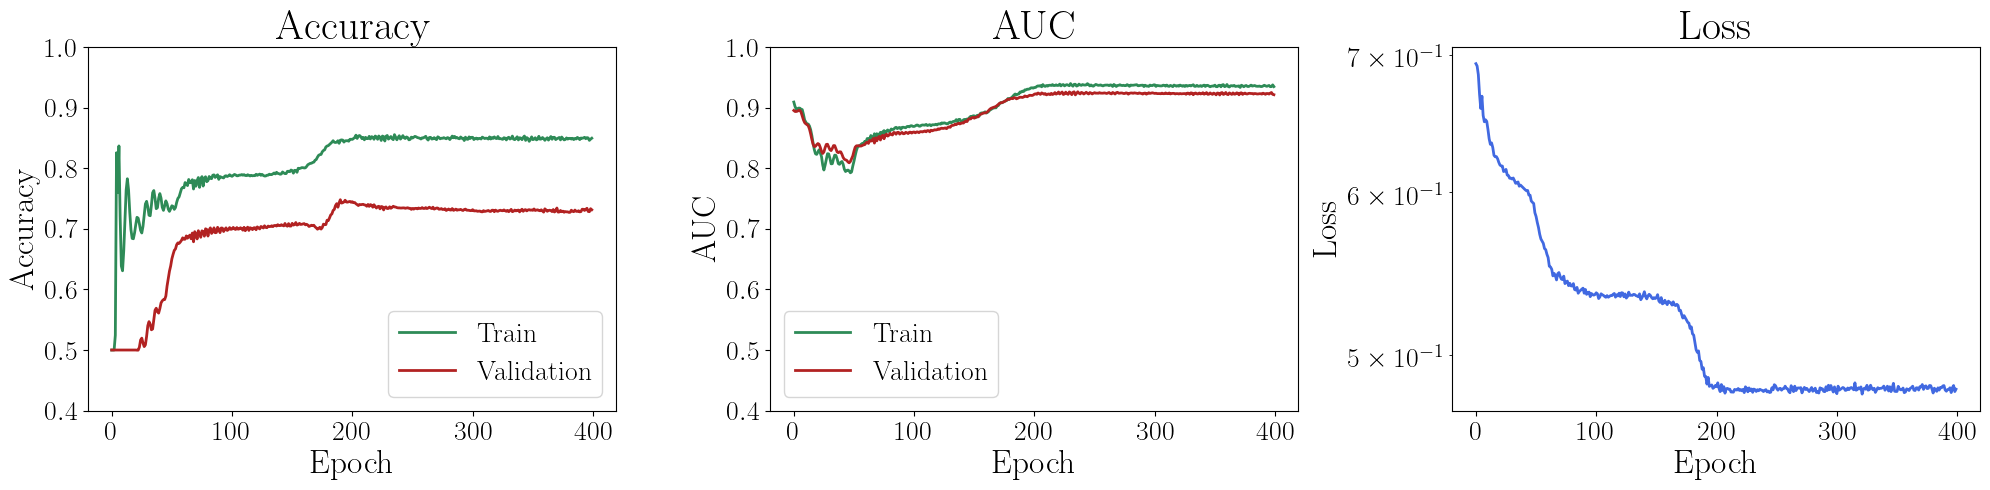

In [311]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

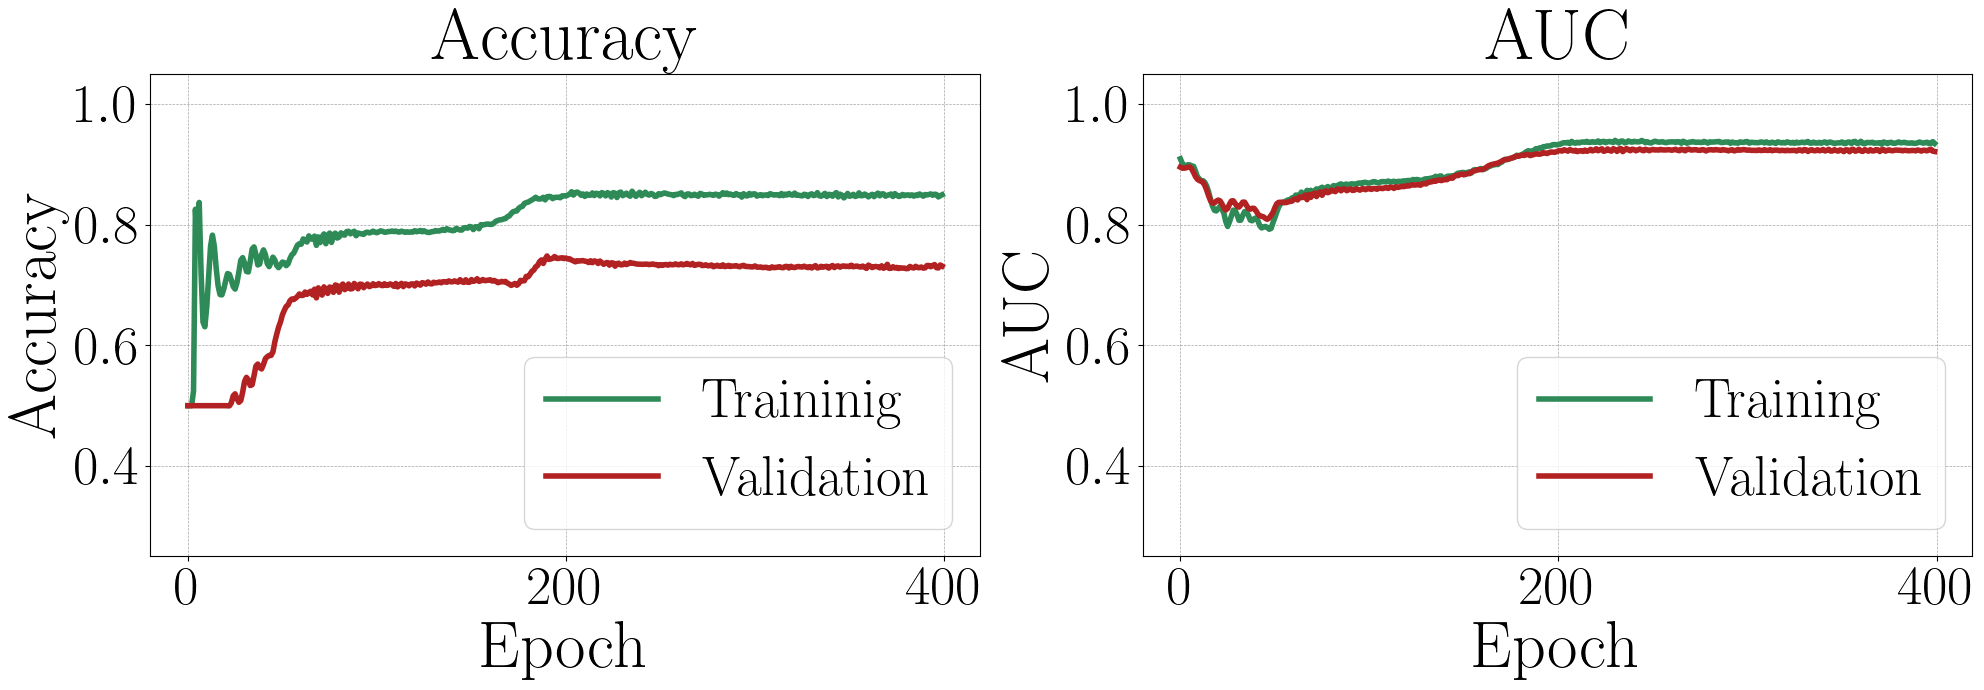

In [312]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

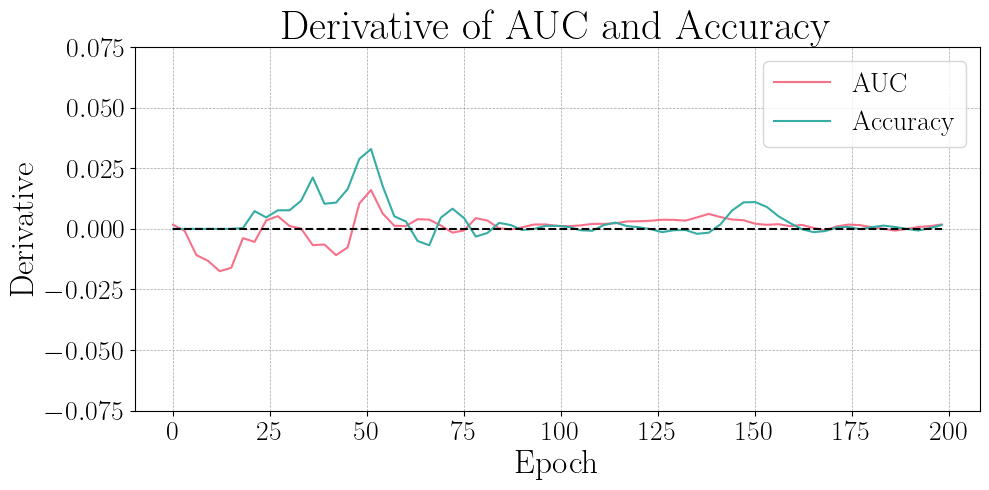

In [160]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

### Best AUC and accuracy

In [ ]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetConv(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=400, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = NetConv(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


## Custom Model (GCN + dropout + BN)

In [313]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetConvPlus(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=400, 
        early_stopping=False, 
        early_stopping_patience=100,
        corrupt=False, 
        corrupt_percentage=0.1,
        save_best_model=False
    )

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:36<00:00, 11.07it/s]

Total training time: 29.7614 seconds.
Total validation time: 6.2162 seconds.


In [314]:
best_model = NetConvPlus(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')


The model has 34,336 trainable parameters
Final Test AUC: 0.9751
Final Test ACC: 0.7866


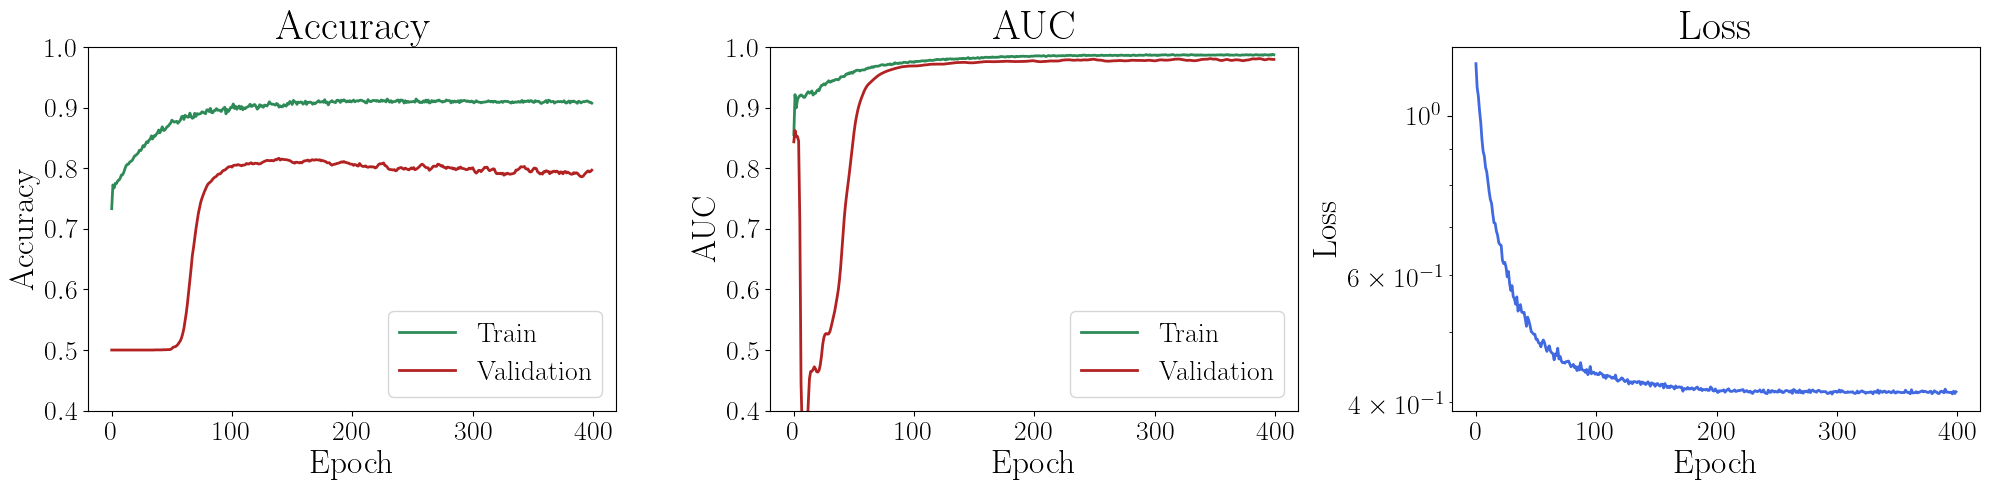

In [315]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

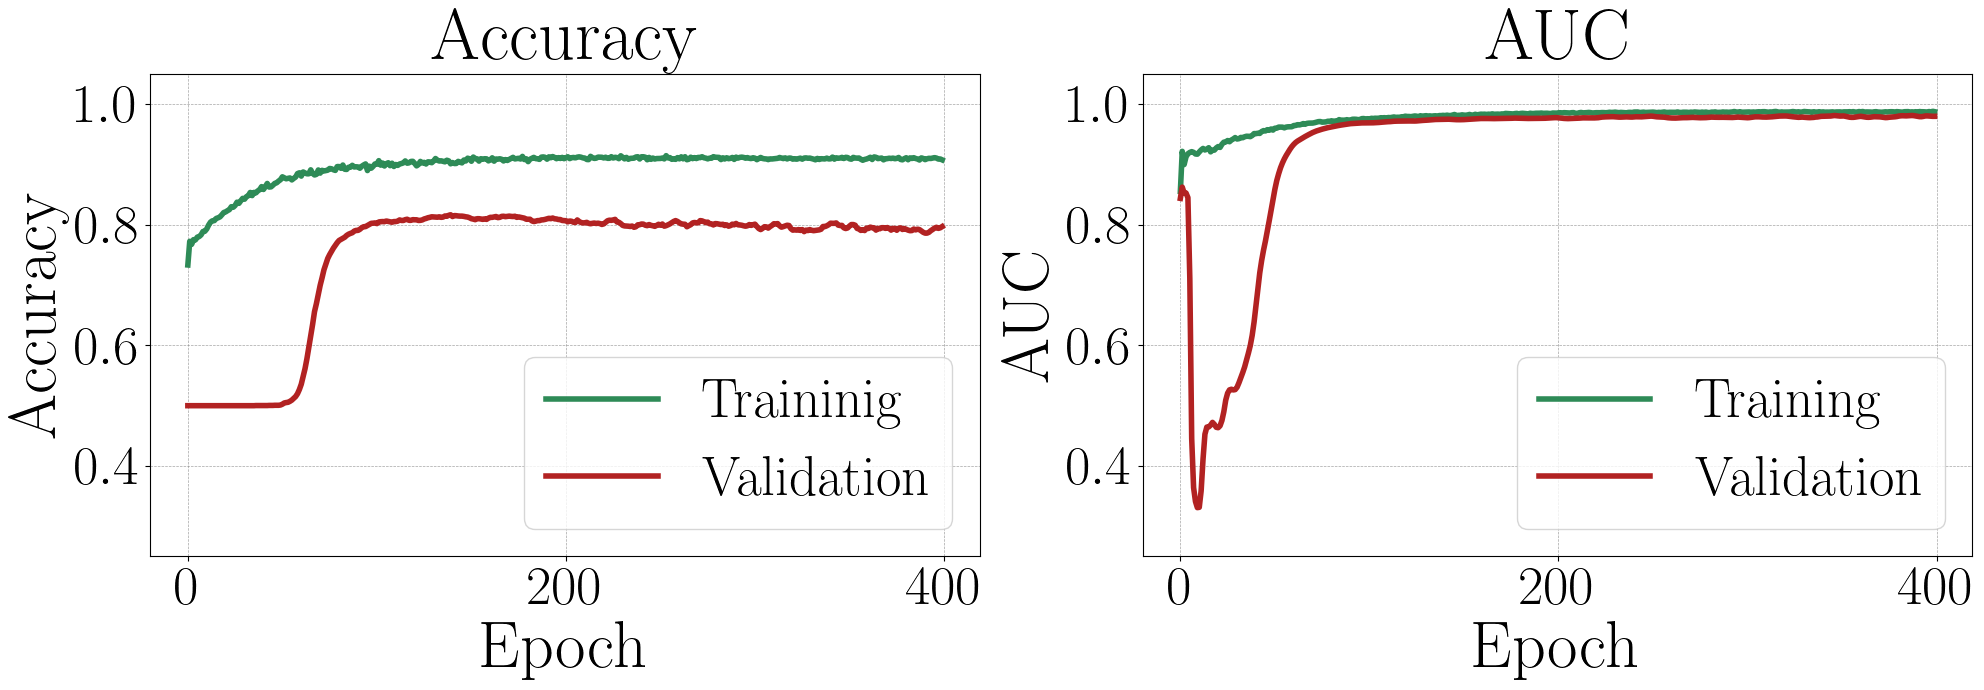

In [316]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

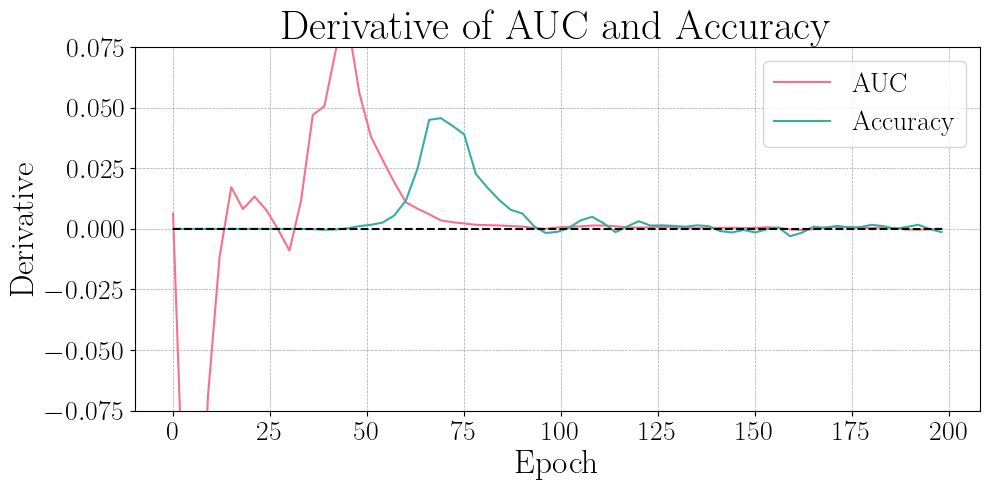

In [247]:
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

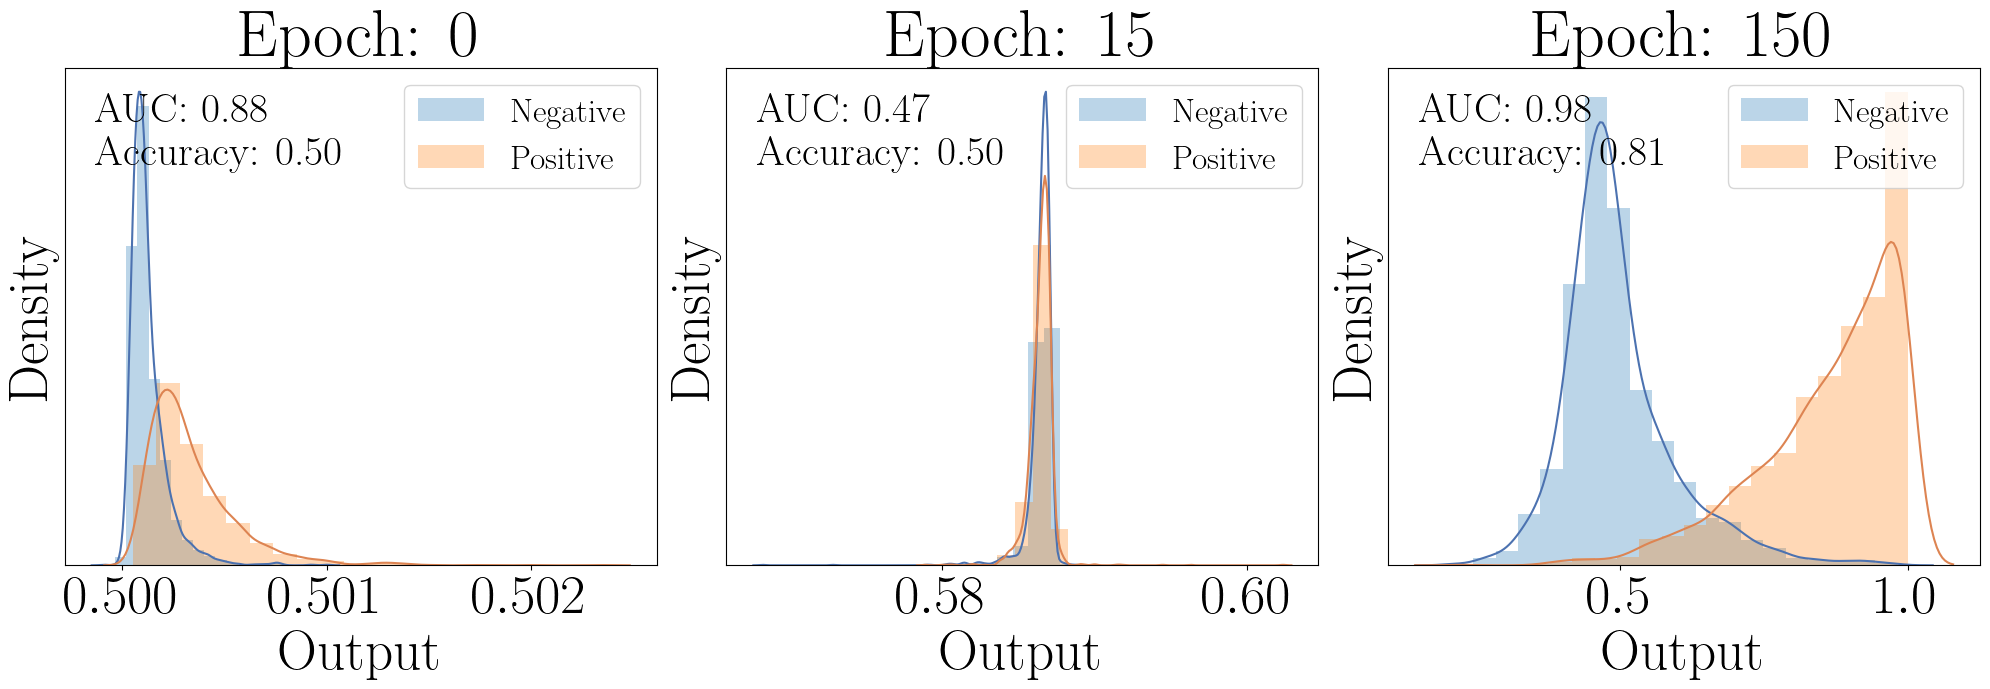

In [321]:
fig, ax = plot_histograms(*get_histograms(train_data, val_data, model, trainer, 
                                          checks=[0, 15, 150]))
fig.show();

### Best AUC and Accuracy

In [ ]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetConvPlus(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = NetConvPlus(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")

### Percentage of Training Data

In [ ]:
# Define percentages
percentages = np.linspace(0.1, 0.9, 9)

# Initialize lists to store mean and std for AUC and accuracy
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

for i in percentages:
    auc_scores = []
    acc_scores = []
    
    for _ in range(5): 
        transform = T.Compose([
            T.NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=1 - 0.05 - i, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        
        dataset = Planetoid("./nets/", name='PubMed', transform=transform)
        train_data, val_data, test_data = dataset[0]
        
        
        model = NetConvPlus(dataset.num_features, 64, 32).to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Initialize the trainer with the model, optimizer, and criterion
        trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

        # Train the model and get results
        # Assicurati di passare g_val e g_test alla funzione train_model
        _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=800, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1 
    )
        best_model = NetConvPlus(dataset.num_features, 64, 32).to(device)
        best_model.load_state_dict(trainer.best_model_state_dict)
        final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)

        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)
    
    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))

In [179]:
# Save results, model structure, and percentages to a pickle file
results = {
    'test_accuracy_auc_mean': test_accuracy_auc_mean,
    'test_accuracy_auc_std': test_accuracy_auc_std,
    'test_accuracy_acc_mean': test_accuracy_acc_mean,
    'test_accuracy_acc_std': test_accuracy_acc_std,
    'model_structure': str(model),  # Save the model structure as a string
    'percentages': percentages.tolist()  # Convert numpy array to list for serialization
}

with open('./files/results_and_model_class.pkl', 'wb') as f:
    pickle.dump(results, f)

In [322]:
# Load results and model structure from the pickle file
with open('./files/results_and_model_class.pkl', 'rb') as f:
    results = pickle.load(f)

# Unpack the results
test_accuracy_auc_mean = results['test_accuracy_auc_mean']
test_accuracy_auc_std = results['test_accuracy_auc_std']
test_accuracy_acc_mean = results['test_accuracy_acc_mean']
test_accuracy_acc_std = results['test_accuracy_acc_std']
model_structure = results['model_structure']
percentages = results['percentages']

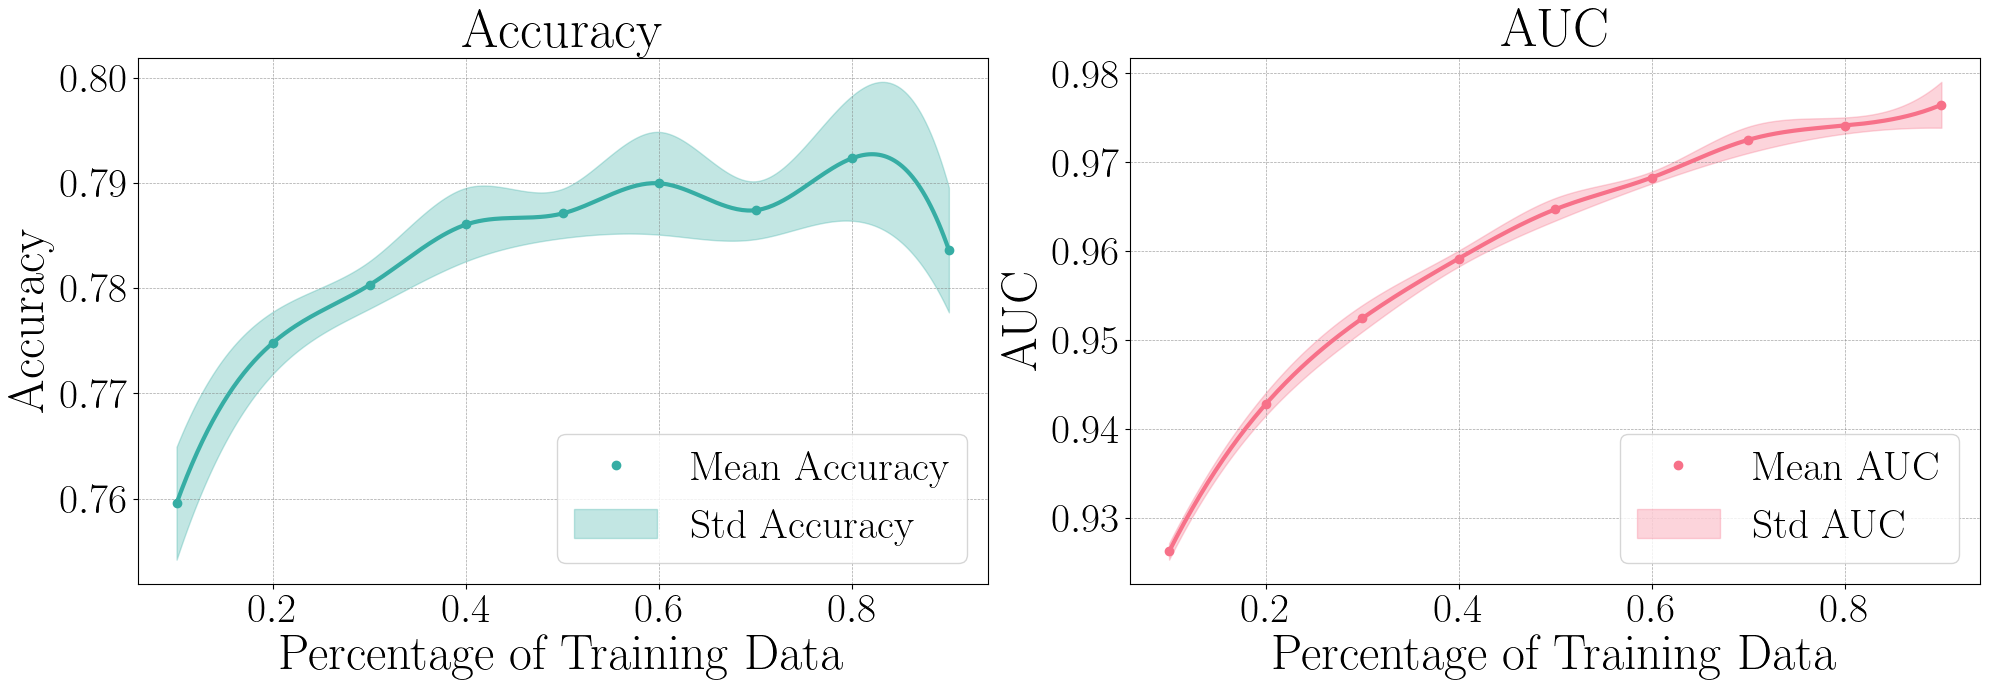

In [327]:
fig, ax = plot_percentage('Percentage of Training Data', percentages, 
                          test_accuracy_auc_mean, test_accuracy_auc_std,
                          test_accuracy_acc_mean, test_accuracy_acc_std)

fig.show();

### Percentage of the Features

In [ ]:
# Initialize lists to store mean and std for AUC and accuracy
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

# Define percentages of features to use
feature_percentages = np.linspace(0.1, 0.9, 9)  # e.g., 10%, 20%, ..., 90% of features

# Fixed train, validation, and test split once
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,  # Fixed sizes
                      add_negative_train_samples=False),
])

dataset = Planetoid("./nets/", name='PubMed', transform=transform)
train_data, val_data, test_data = dataset[0]

# Original number of features
num_features = train_data.x.size(1)  # Assuming `x` is the node feature matrix (N x F)
for perc in feature_percentages:
    auc_scores = []
    acc_scores = []

    # Determine the number of features to use for this percentage
    num_features_to_use = min(int(perc * num_features), num_features)  # Ensure it does not exceed actual number of features

    for _ in range(5):  # Repeat 5 times to average
        # Shuffle and select a percentage of features
        selected_features_idx = np.random.permutation(num_features)[:num_features_to_use]
        
        # Create copies of the data and apply the selected features to the dataset
        train_data_copy = train_data.clone()
        val_data_copy = val_data.clone()
        test_data_copy = test_data.clone()

        # Apply the selected features to the dataset
        train_data_copy.x = train_data_copy.x[:, selected_features_idx]
        val_data_copy.x = val_data_copy.x[:, selected_features_idx]
        test_data_copy.x = test_data_copy.x[:, selected_features_idx]

        # Initialize model, optimizer, and criterion
        model = NetConvPlus(num_features_to_use, 64, 32).to(device)  # Update input size
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Initialize the trainer with the model, optimizer, and criterion
        trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

        # Train the model and evaluate
        _, _, _, _, _, run_timestamp = trainer.train_model(
            train_data=train_data_copy,
            val_data=val_data_copy,
            epochs=800,
            early_stopping=True,
            early_stopping_patience=100,
        )
        best_model = NetConvPlus(num_features_to_use, 64, 32).to(device)
        best_model.load_state_dict(trainer.best_model_state_dict)
        final_test_acc, final_test_auc = trainer.test(test_data_copy)
        
        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)

    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))


In [ ]:
data_to_save = {
    "test_accuracy_auc_mean": test_accuracy_auc_mean,
    "test_accuracy_auc_std": test_accuracy_auc_std,
    "test_accuracy_acc_mean": test_accuracy_acc_mean,
    "test_accuracy_acc_std": test_accuracy_acc_std,
    'model_structure': str(model),  # Save the model structure as a string
    'percentages': feature_percentages.tolist()
}

# Save the data to a pickle file
pickle_file_path = './files/test_accuracy_results_features.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(data_to_save, f)

In [328]:
# Load the data from the pickle file
with open ('./files/test_accuracy_results_features.pkl', 'rb') as f:
    data = pickle.load(f)

# Unpack the data
test_accuracy_auc_mean = data["test_accuracy_auc_mean"]
test_accuracy_auc_std = data["test_accuracy_auc_std"]
test_accuracy_acc_mean = data["test_accuracy_acc_mean"]
test_accuracy_acc_std = data["test_accuracy_acc_std"]
feature_percentages = data["percentages"]

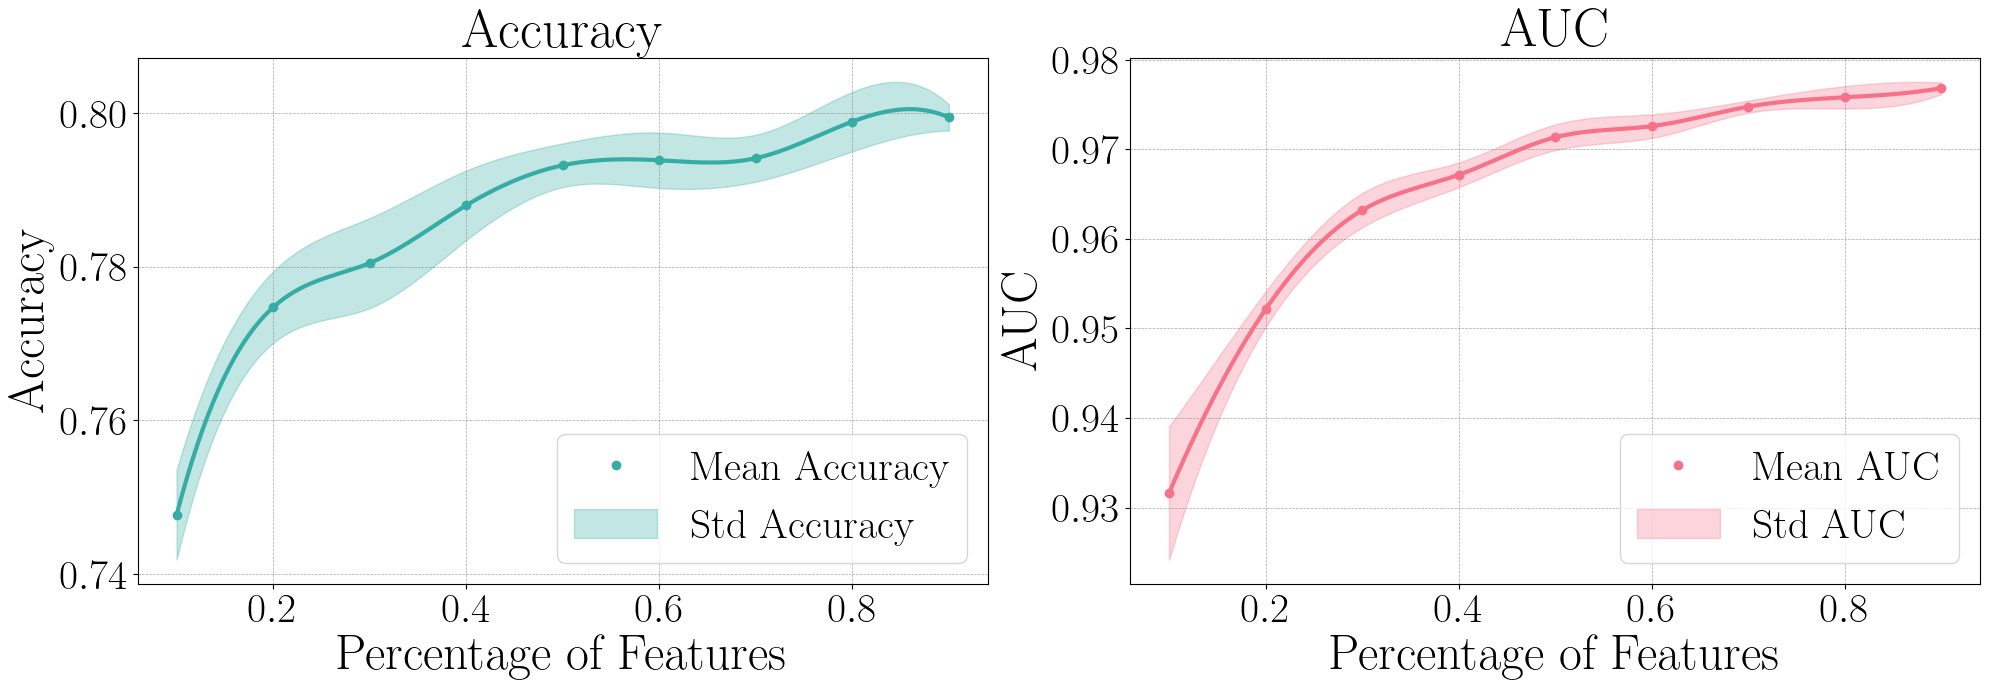

In [329]:
fig, ax = plot_percentage('Percentage of Features', feature_percentages,
                          test_accuracy_auc_mean, test_accuracy_auc_std,
                          test_accuracy_acc_mean, test_accuracy_acc_std)

fig.show();

### Heat Map: Number of Channels

In [ ]:
# Download the dataset and apply the transformation
dataset = Planetoid("./nets/", name='PubMed', transform=transform)

hidden_units = [8, 16, 32, 64, 128, 256]
output_units = [4, 8, 16, 32, 64, 128]

results_matrix = np.zeros((len(hidden_units), len(output_units)))

for i, hidden in enumerate(hidden_units):
    for j, output in enumerate(output_units):
        auc, _ = scan_nchannels(dataset, hidden, output)
        results_matrix[i, j] = auc
        print(f"Hidden units: {hidden}, Output units: {output} -> AUC: {auc:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_matrix, annot=True, xticklabels=output_units, yticklabels=hidden_units, cmap='viridis')
plt.xlabel('Output Units')
plt.ylabel('Hidden Units')
plt.title('AUC for different configurations of Hidden and Output Units')

### Heat Map: Learning Rate

In [ ]:
# Define learning rates to evaluate
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]
results_matrix = np.zeros((len(learning_rates), 2)) 

# Evaluate the model for different learning rates
for i, lr in enumerate(dataset, learning_rates):
    auc, acc = scan_lr(dataset, lr)
    results_matrix[i, 0] = auc  # AUC
    results_matrix[i, 1] = acc  # Accuracy
    print(f"Learning rate: {lr} -> AUC: {auc:.4f}, Accuracy: {acc:.4f}")

In [ ]:
# Plot AUC results
plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 0].reshape(-1, 1), annot=True, xticklabels=['AUC'], yticklabels=learning_rates, cmap='viridis')
plt.title('AUC for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')

In [ ]:
# Plot Accuracy results
plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 1].reshape(-1, 1), annot=True, xticklabels=['Accuracy'], yticklabels=learning_rates, cmap='viridis')
plt.title('Accuracy for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')

### Scan for Dropout

In [ ]:
dropout_rates = np.linspace(0.1, 0.7, 7)
values = {"Dropout": {}}  

for i in range(10):
    for dropout in dropout_rates:
        if dropout not in values["Dropout"]:
            values["Dropout"][dropout] = {"AUC": [], "Accuracy": []}
        
        auc, acc = scan_dropout(dataset, dropout)
        
        values["Dropout"][dropout]["AUC"].append(auc)
        values["Dropout"][dropout]["Accuracy"].append(acc)

for dropout in values["Dropout"]:
    auc_values = values["Dropout"][dropout]["AUC"]
    acc_values = values["Dropout"][dropout]["Accuracy"]
    
    values["Dropout"][dropout]["MeanAUC"] = np.mean(auc_values)
    values["Dropout"][dropout]["MeanAcc"] = np.mean(acc_values)
    values["Dropout"][dropout]["StdAUC"] = np.std(auc_values)
    values["Dropout"][dropout]["StdAcc"] = np.std(acc_values)

pprint.pprint(values)

In [ ]:
print("Mean AUC and Accuracy for different dropout rates:")
for dropout, metrics in values["Dropout"].items():
    print(f"Dropout {dropout}: Mean AUC = {metrics['MeanAUC']}, Mean Accuracy = {metrics['MeanAcc']}")
    print(f"Dropout {dropout}: Std AUC = {metrics['StdAUC']}, Std Accuracy = {metrics['StdAcc']}")

In [ ]:
dropout_rates = list(values["Dropout"].keys())
test_accuracy_auc_mean = [np.mean(values["Dropout"][dropout]["AUC"]) for dropout in dropout_rates]
test_accuracy_auc_std = [np.std(values["Dropout"][dropout]["AUC"]) for dropout in dropout_rates]
test_accuracy_acc_mean = [np.mean(values["Dropout"][dropout]["Accuracy"]) for dropout in dropout_rates]
test_accuracy_acc_std = [np.std(values["Dropout"][dropout]["Accuracy"]) for dropout in dropout_rates]

# Plotting AUC results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(dropout_rates, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(dropout_rates, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', label="Learning rate", alpha=0.2)  # Area di deviazione standard per AUC
plt.xlabel('Dropout Rate')
plt.ylabel('AUC Score')
plt.title('Mean AUC for Different Dropout Rates')
plt.grid(True)
plt.legend()
plt.show()

## Attention-Based Model

In [206]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetAttention(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=400, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1
    )

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [01:13<00:00,  5.46it/s]

Total training time: 57.6149 seconds.
Total validation time: 15.3774 seconds.


In [207]:
best_model = NetAttention(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(best_model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

The model has 68,832 trainable parameters
Final Test AUC: 0.9546
Final Test ACC: 0.8056


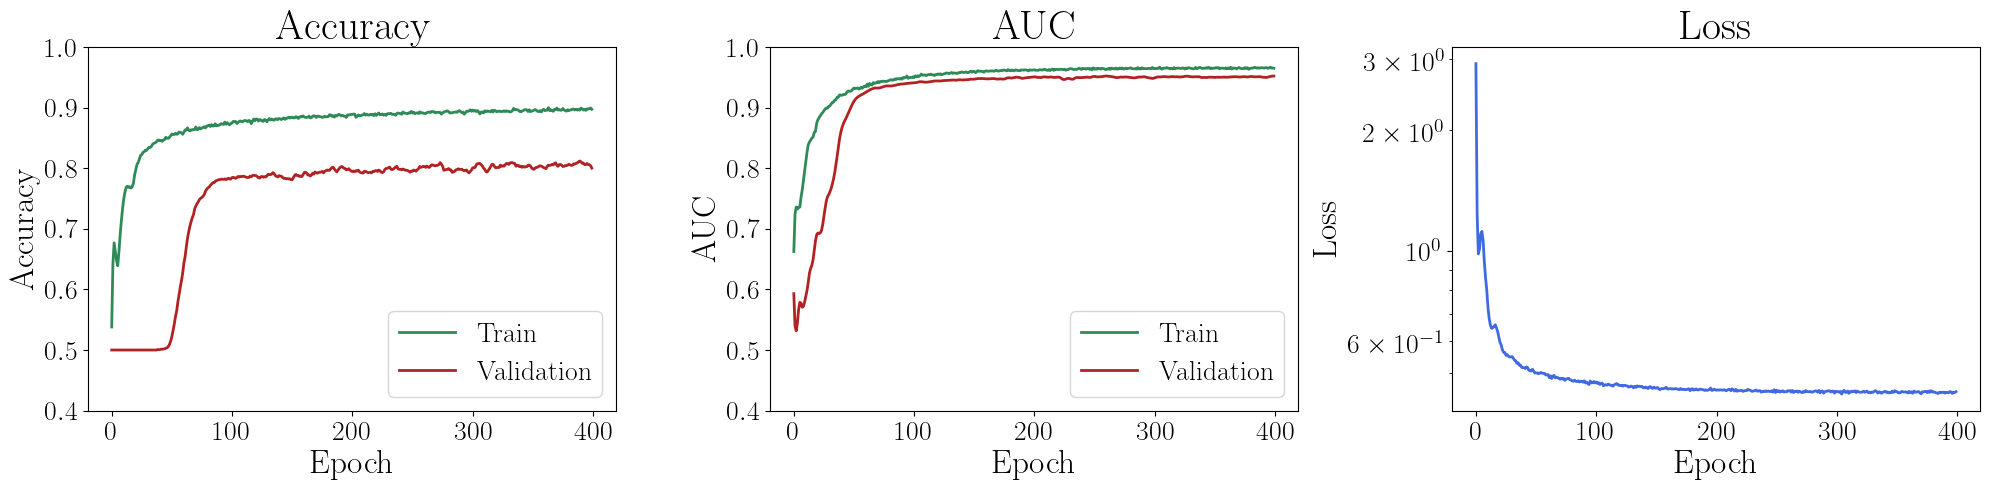

In [208]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

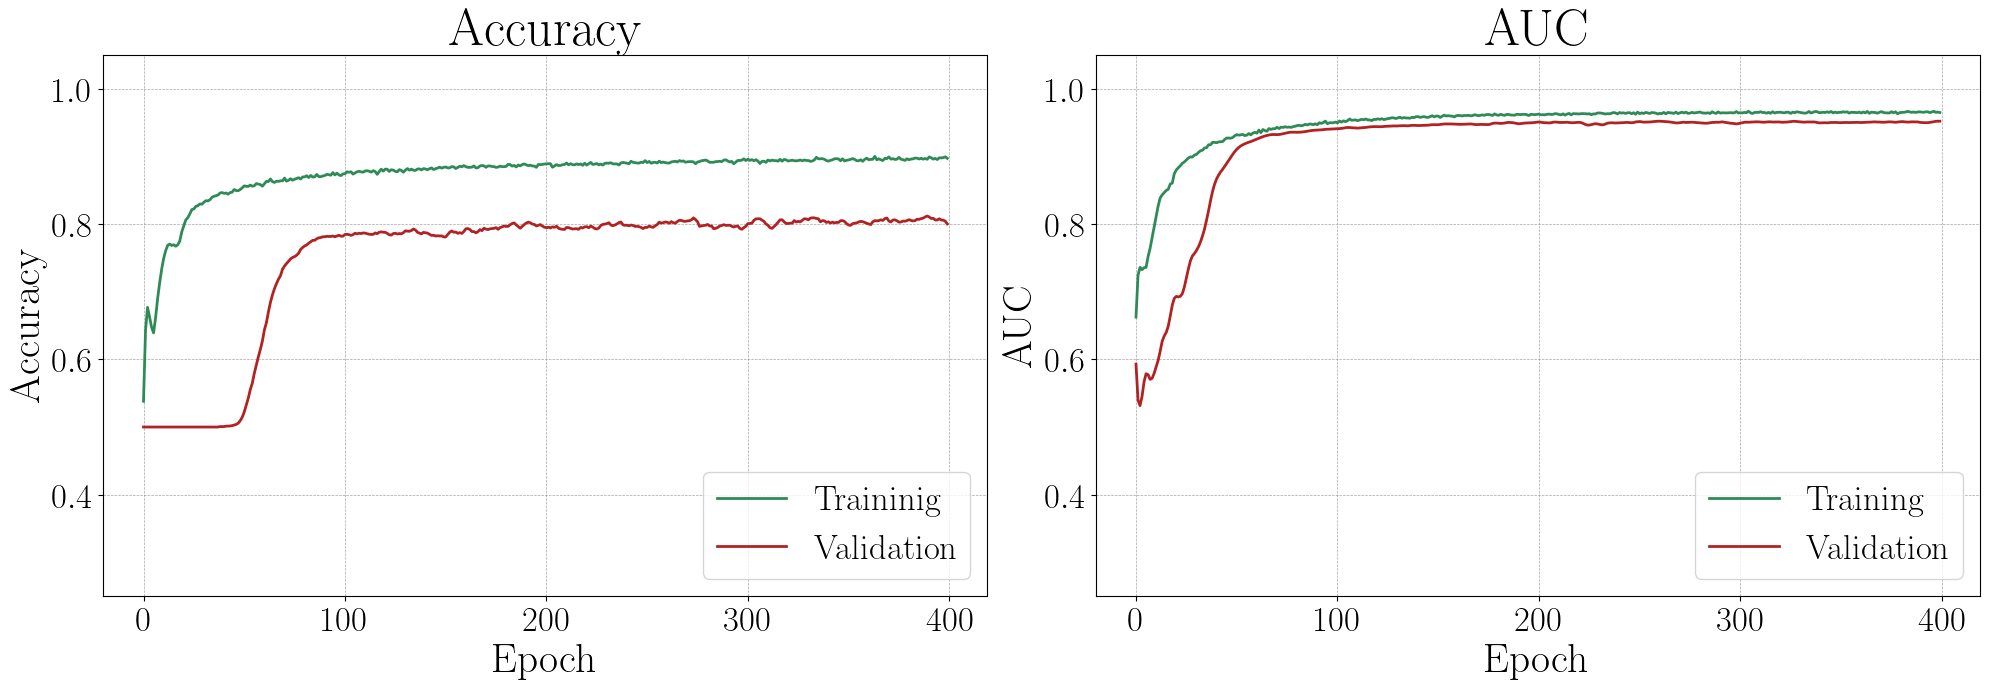

In [209]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

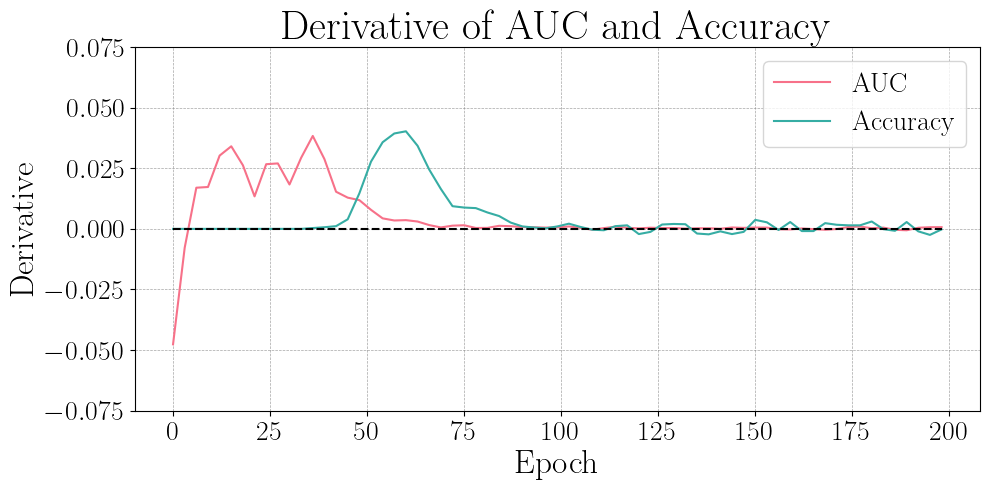

In [210]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

### Best AUC and accuracy

In [ ]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetAttention(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=100,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = NetAttention(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


## Recurrent Layer Model

In [ ]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetRecurrent(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=400, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1
    )

In [ ]:
best_model = NetRecurrent(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(best_model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

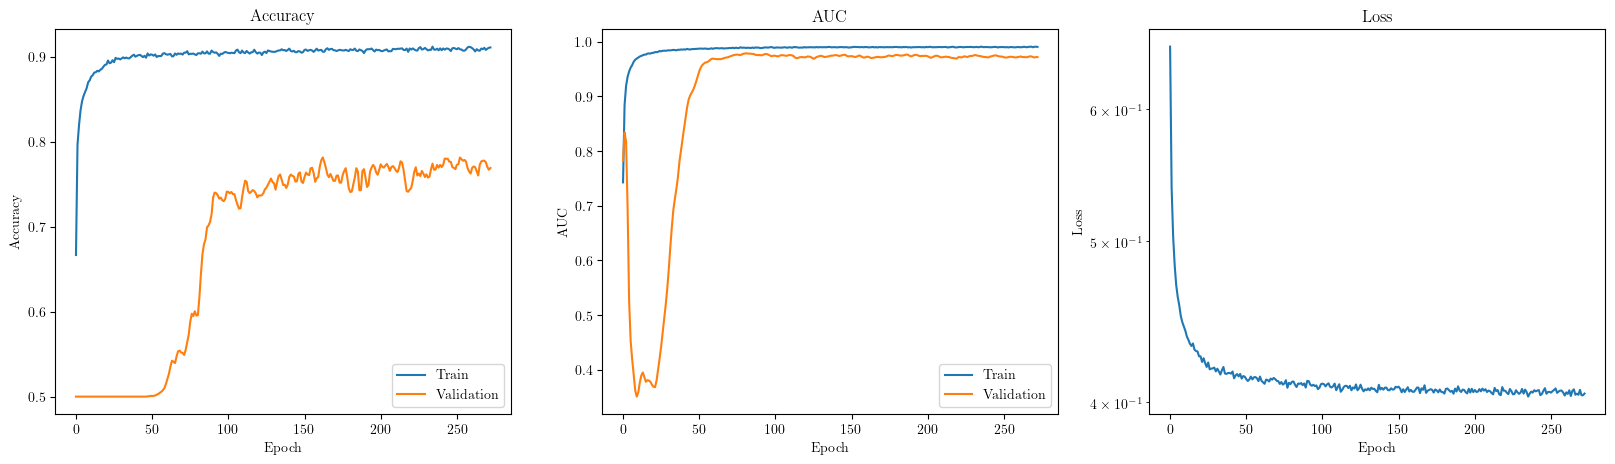

In [24]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

In [ ]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

In [ ]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

### Best AUC and accuracy

In [ ]:
test_acc, test_auc, test_mrr = [], [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetRecurrent(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=True
        )
    best_model = NetRecurrent(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


## VAE model

In [ ]:
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 128       # Number of hidden channels
out_channels = 64           # Number of output features

# Create the model instance (Variational Autoencoder)
model = NetVAE(in_channels, hidden_channels, out_channels).to(device)

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Initialize the trainer
trainer = TrainerVAE(model=model, optimizer=optimizer, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
    train_data=train_data, 
    val_data=val_data, 
    epochs=800, 
    early_stopping=True, 
    early_stopping_patience=200,
    
)

In [ ]:
# Load the best model's weights into a new model instance for testing
best_model = NetVAE(in_channels, hidden_channels, out_channels).to(device)
trainer.duplicate_best_model_weights(best_model, f'best_model_{run_timestamp}.pth')
print(f'The model has {count_parameters(best_model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')


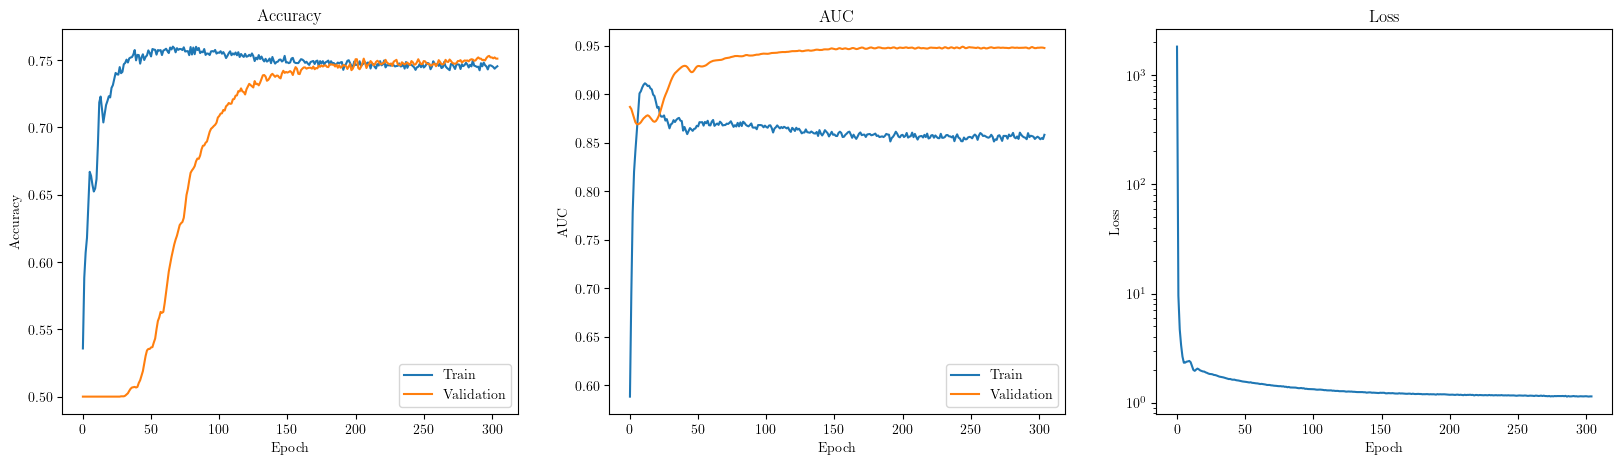

In [30]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

(-0.075, 0.075)

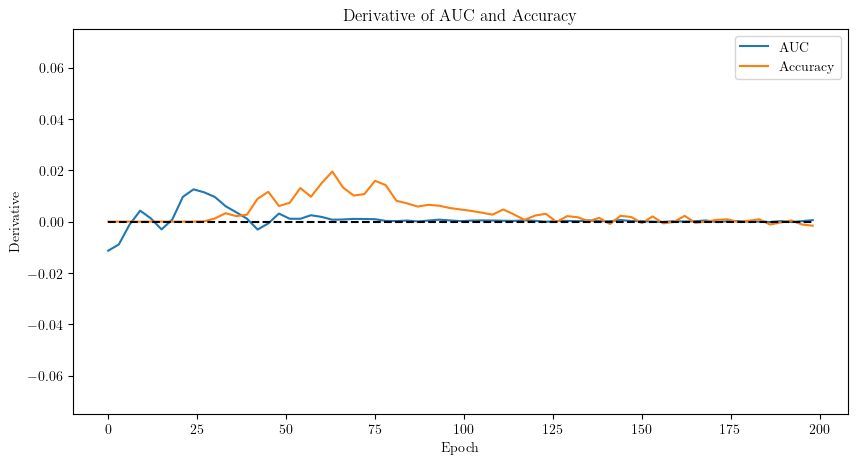

In [31]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

In [32]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

Final Test AUC: 0.9481
Final Test ACC: 0.7482


### Best AUC and accuracy

In [ ]:
test_acc, test_auc, test_mrr = [], [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 128 # Number of hidden channels
    out_channels = 64 # Number of output features

    # Create the model instance
    model = NetVAE(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerVAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=100,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=True
        )
    best_model = NetVAE(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


# Barabasi topology

In [330]:
# Create the random graph
g = nx.barabasi_albert_graph(2001, 1)
print(f"Number of edges: {g.number_of_edges()}")

# Create the dataset class
dataset = CustomGraphDataset("./data/Custom", *customGraphData(g))

# Define the transformation
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.10, is_undirected=True,
                     add_negative_train_samples=False),
])

# Apply transformations
dataset.transform = transform
train_data, val_data, test_data = dataset[0]

# Get the number of features
num_features = dataset.num_features

Number of edges: 2000


In [331]:
print("Train data edge index:", train_data.edge_index.shape)
print("Train data edge label index:", train_data.edge_label_index.shape)
print("Val data edge index:", val_data.edge_index.shape)
print("Val data edge label index:", val_data.edge_label_index.shape)
print("Test data edge index:", test_data.edge_index.shape)
print("Test data edge label index:", test_data.edge_label_index.shape)

Train data edge index: torch.Size([2, 3400])
Train data edge label index: torch.Size([2, 1700])
Val data edge index: torch.Size([2, 3400])
Val data edge label index: torch.Size([2, 200])
Test data edge index: torch.Size([2, 3600])
Test data edge label index: torch.Size([2, 400])


In [332]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetConvPlus(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=200, 
        early_stopping=False, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1,
        save_best_model=False
    )

100%|██████████| 200/200 [00:02<00:00, 94.42it/s]

Total training time: 1.5106 seconds.
Total validation time: 0.5951 seconds.


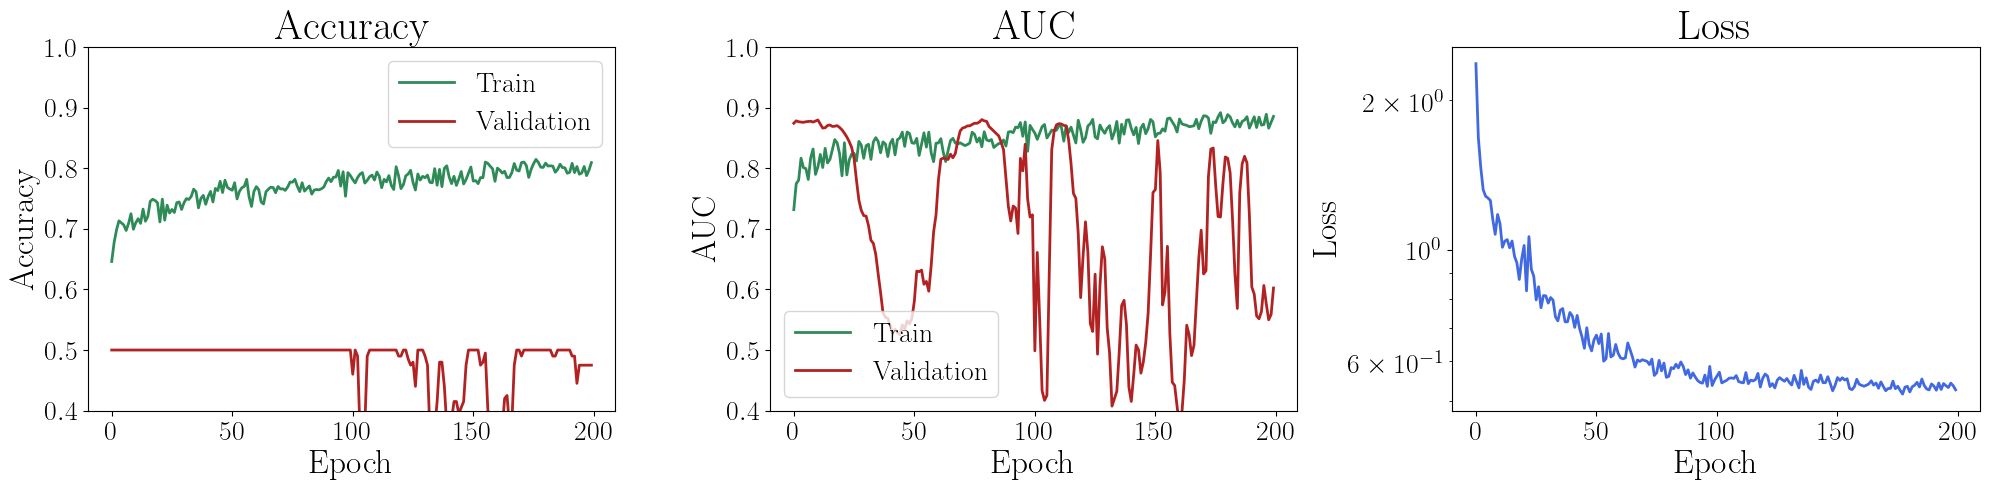

In [333]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

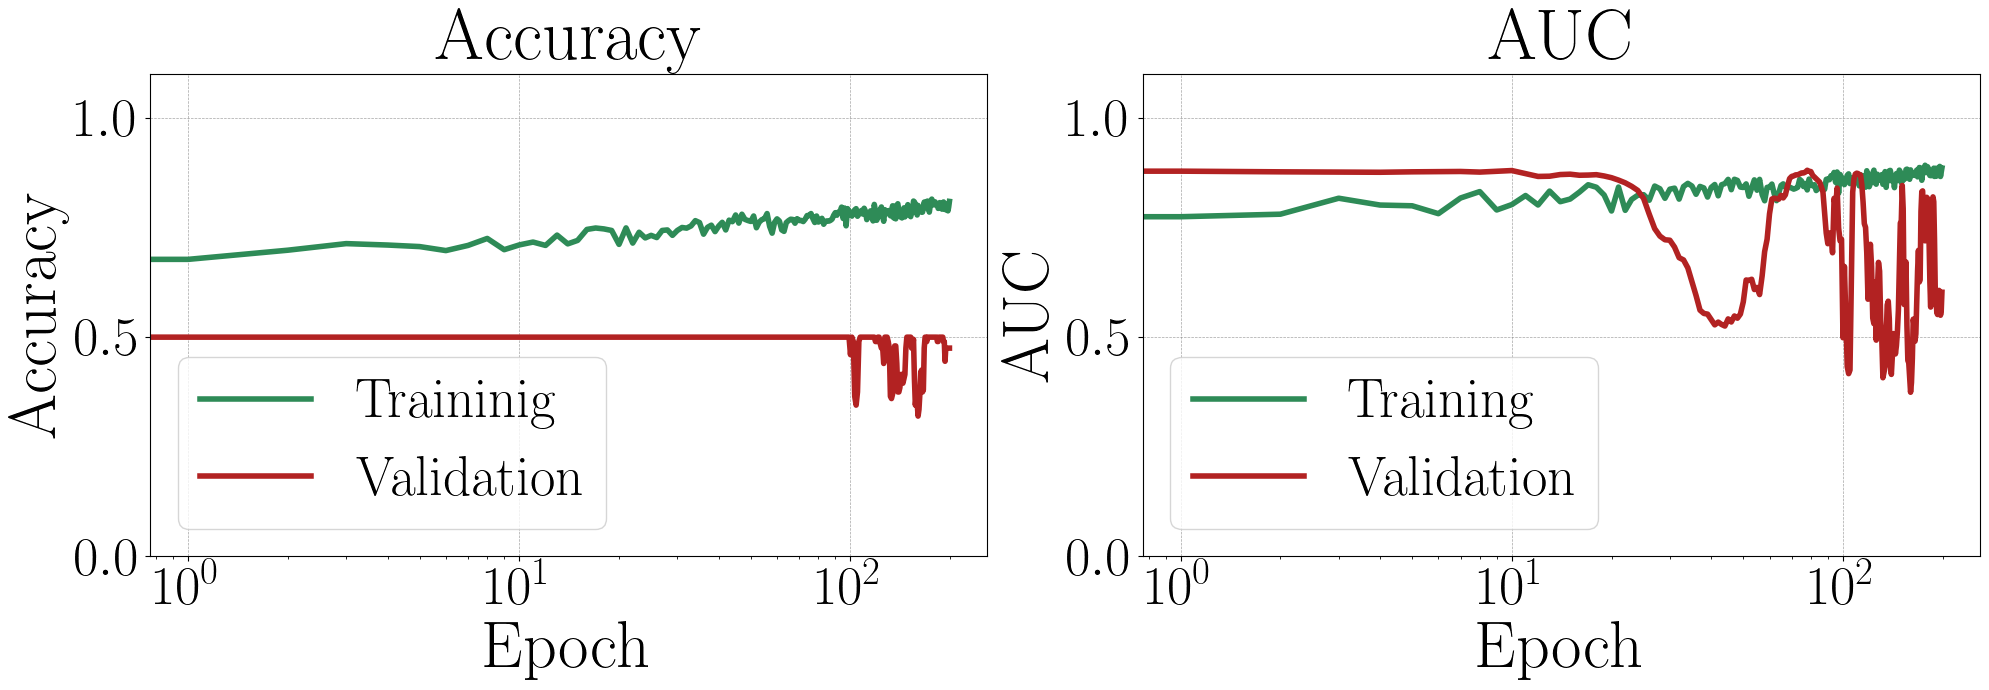

In [347]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=True)

ax[0].set_ylim(0, 1.1)
ax[1].set_ylim(0, 1.1)
ax[0].legend(loc="lower left", fontsize=40)
ax[1].legend(loc="lower left", fontsize=40)
fig.show();

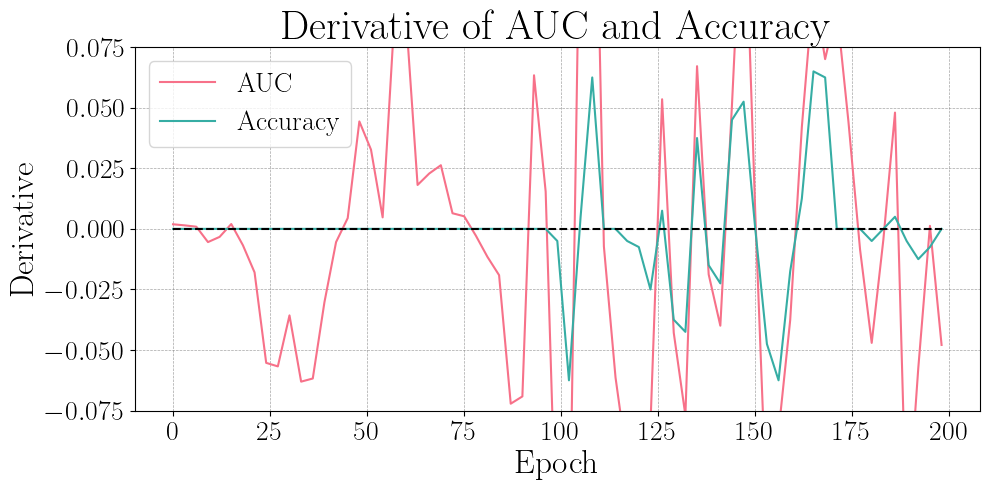

In [335]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

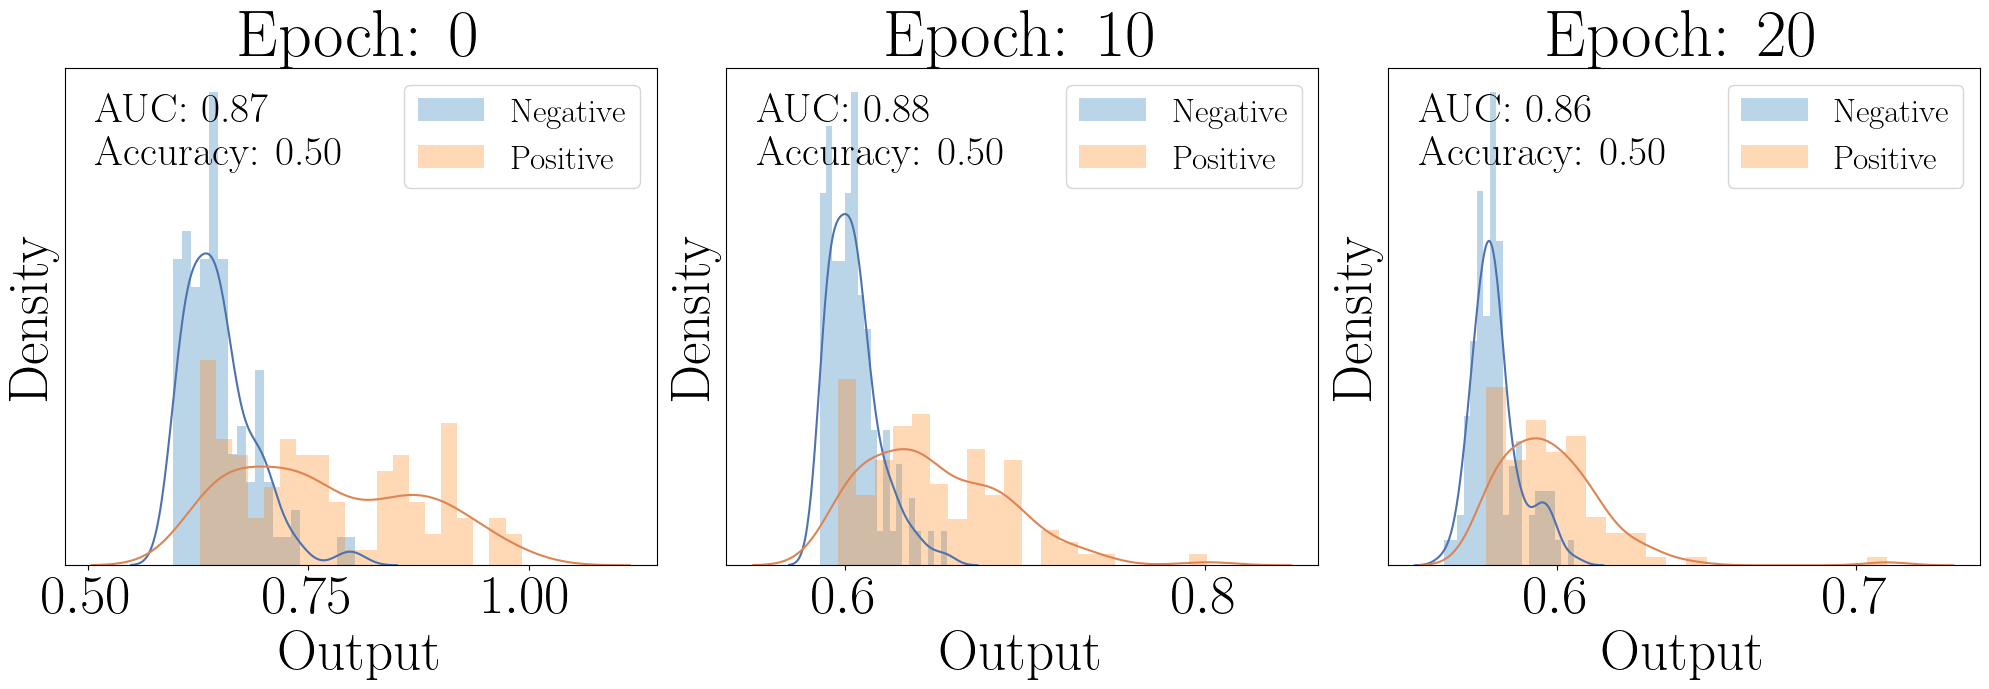

In [336]:
fig, ax = plot_histograms(*get_histograms(train_data, val_data, model, trainer, 
                                          checks=[0, 10, 20]))
fig.show();